jit after {'jit': True, 'jit_options': {'flags': '-Ofast'}, 'compiler': 'shell'}
number of joints = 4


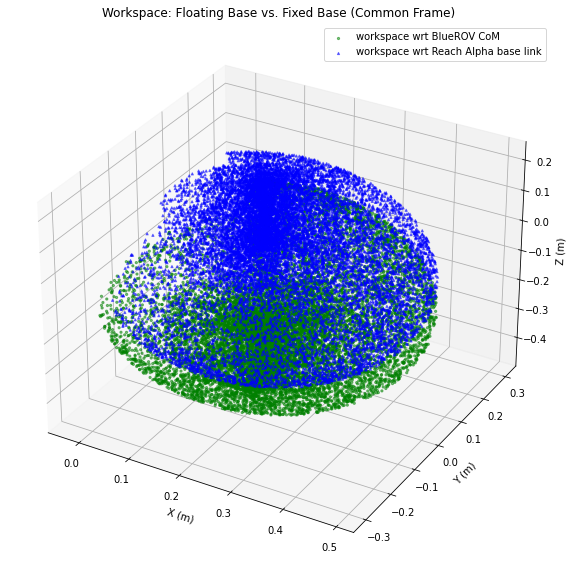

Task is out-of-workspace.


In [1]:
%run forward_kinematics.ipynb

In [2]:
J = dIFF_KinJ4
lambda_val = 0.01  # Adjust damping factor as needed
J_plus = J.T @ cs.inv(J @ J.T + lambda_val**2 * cs.SX.eye(J.size1()))

# J_plus = cs.pinv(J)
I = cs.SX.eye(J.size2())

In [3]:
# --- Secondary Task: joint limit cost---
# stay away from the joint limits 

sigma_wq_i = 0
for i in range(arm_ss.n.size1()):
    q_i_bar = (arm_ss.uvms_ul[i] + arm_ss.uvms_ll[i])/2
    wq_i = ((arm_ss.n[i] - q_i_bar)/(arm_ss.uvms_ul[i] - arm_ss.uvms_ll[i]))**2
    sigma_wq_i = sigma_wq_i + wq_i
    
    
wq =  (1/(2*arm_ss.n.size1()))*sigma_wq_i

J_wq = cs.jacobian(wq, arm_ss.n)

In [4]:
# --- Secondary Task: Collision-avoidance cost ---
# Suppose you have a function that calculates w_col(q)
# w_col = collision_cost(q, base_geometry, manipulator_geometry)
# J_col = jacobian(w_col, q)

In [5]:
# Weighted combination of the two secondary tasks
qdot_sec = cs.diag(arm_ss.w_k)@J_wq.T # + cs.diag(arm_ss.w_k1)@J_col.T

In [6]:
# operation space error
X_c = T4_euler
X_error = arm_ss.X_d - X_c

# Compute desired velocity using a proportional gain
Kp = cs.diag(arm_ss.IK_kp)  # Gain matrix
dX_d = Kp @ X_error  # Proportional control law

# Use computed velocity in inverse kinematics (nullspace injection of a redundant robot)
IK_qdot = J_plus @ dX_d + (I - J_plus @ J) @ qdot_sec

# Integrate velocity to get position update
et = cs.SX.sym('et')  # Time step
q_next = arm_ss.n + IK_qdot * et  # Euler integration

# Define the new function for position-based IK
IK_q_func = cs.Function(
    'uvms_iK',
    [arm_ss.n, arm_ss.X_d, arm_ss.uvms_ul, arm_ss.uvms_ll, arm_ss.IK_kp, arm_ss.w_k, arm_ss.base_T, et],
    [q_next, IK_qdot, X_error]
)

N_sim = 3500
F_IK = IK_q_func.fold(N_sim)
F_IK.save('uvms_iK.casadi') # for ros2
F_IK_sim = IK_q_func.mapaccum(N_sim)

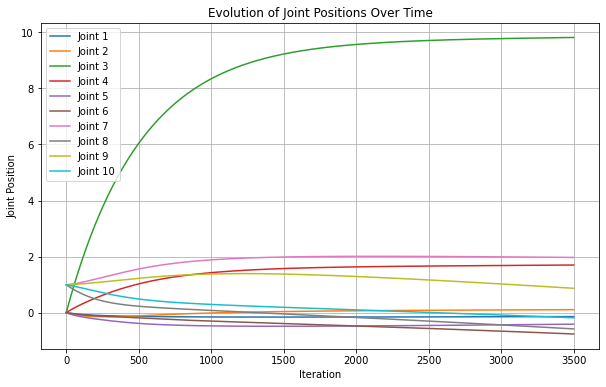

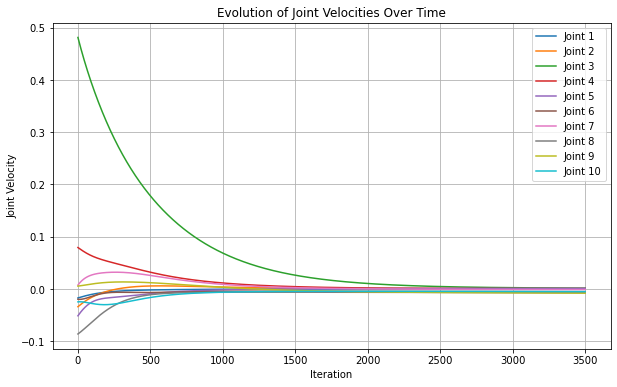

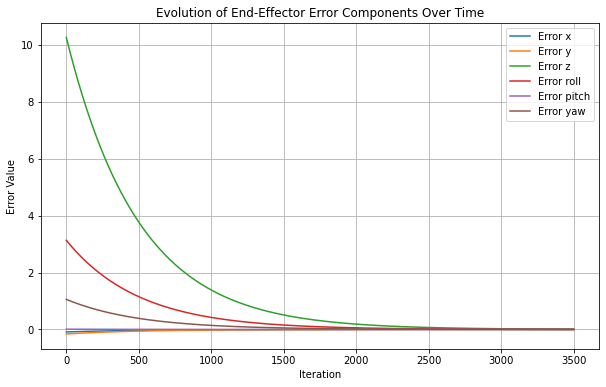

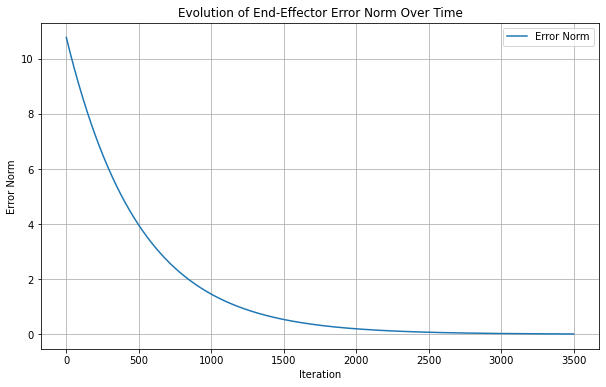

In [ ]:
# redundant inverse kinematics simulation

# Parameters
n_et = cs.DM([0, 0, 0, 0.01, 0.01, 0.01, 1, 1, 1, 1])
des_X = cs.DM([0, 0, 10, 0, 0, 0])  # Desired end-effector pose
uvms_ul = cs.DM([10, 10, 10, cs.pi, cs.pi, cs.pi, 2*cs.pi, 2*cs.pi, 2*cs.pi, 2*cs.pi])
uvms_ll = cs.DM([-10, -10, -10, -cs.pi, -cs.pi, -cs.pi, 0, 0, 0, 0])
k0 = cs.DM([0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
base_T = alpha.base_T0  
dt = cs.DM(0.04)  # Time step



n_et_history , dn_et_history, x_err_history = F_IK_sim(n_et,
                              des_X,
                            uvms_ul,
                            uvms_ll,
                            k0,
                            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # assuming arm_ss.n size is 10 as per your example
                            base_T,
                            dt)

# Plot joint evolution over time (joint positions)
plt.figure(figsize=(10, 6))
for i in range(n_et_history.shape[0]):
    plt.plot(n_et_history[i, :].T, label=f'Joint {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Joint Position')
plt.title('Evolution of Joint Positions Over Time')
plt.legend()
plt.grid()
plt.show()

# Plot joint velocities over time
plt.figure(figsize=(10, 6))
for i in range(dn_et_history.shape[0]):
    plt.plot(dn_et_history[i, :].T, label=f'Joint {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Joint Velocity')
plt.title('Evolution of Joint Velocities Over Time')
plt.legend()
plt.grid()
plt.show()

# Define labels for each error component
error_labels = ['x', 'y', 'z', 'roll', 'pitch', 'yaw']

plt.figure(figsize=(10, 6))
for i, label in enumerate(error_labels):
    plt.plot(x_err_history[i, :].T, label=f'Error {label}')
plt.xlabel('Iteration')
plt.ylabel('Error Value')
plt.title('Evolution of End-Effector Error Components Over Time')
plt.legend()
plt.grid(True)
plt.show()


# Compute the norm of the error at each iteration
error_norm = np.linalg.norm(x_err_history, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(error_norm, label='Error Norm')
plt.xlabel('Iteration')
plt.ylabel('Error Norm')
plt.title('Evolution of End-Effector Error Norm Over Time')
plt.legend()
plt.grid(True)
plt.show()
